In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from experiment_classifier import ClsModel
from templates import *
from templates_cls import *

C:\Users\tsj_g\2021118_yoshiike\.venv\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [4]:
device = "cuda:0"
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f"checkpoints/{conf.name}/last.ckpt", map_location="cpu")
model.load_state_dict(state["state_dict"], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [5]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...


In [6]:
from_dir = "imgs_test/imgs_pose"
for i, file in enumerate(os.listdir(from_dir)):
    print(f"{i:2}: {file}")

 0: ookawa_angry2_faceless.png
 1: ookawa_default_faceless.png
 2: yotaka_angry2_faceless.png
 3: yotaka_angry_faceless.png
 4: yotaka_default_faceless.png
 5: yotaka_gj_faceless.png
 6: yotaka_smile_faceless.png


In [8]:
to_dir = "imgs_align"
for i, file in enumerate(os.listdir(to_dir)):
    print(f"{i:2}: {file}")

 0: azuki_default.png
 1: ceo_default.png
 2: check1.png
 3: check2.png
 4: danda_default.png
 5: detective.png
 6: detective_02.png
 7: idPhoto.png
 8: mio_happy.png
 9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_angry.png
32: yotaka_angry2.png
33: yotaka_bald.png
34: yotaka_bushy.png
35: yotaka_default.png
36: yotaka_gj.png
37: yotaka_smile.png
38: yotaka_smile2.png


In [12]:
data = ImageDataset(from_dir, image_size=conf.img_size, exts=["jpg", "JPG", "png"], do_augment=False)
batch_from = torch.stack([data[4]["img"], data[2]["img"]])

data2 = ImageDataset(to_dir, image_size=conf.img_size, exts=["jpg", "JPG", "png"], do_augment=False)
batch_to = data2[30]["img"][None]

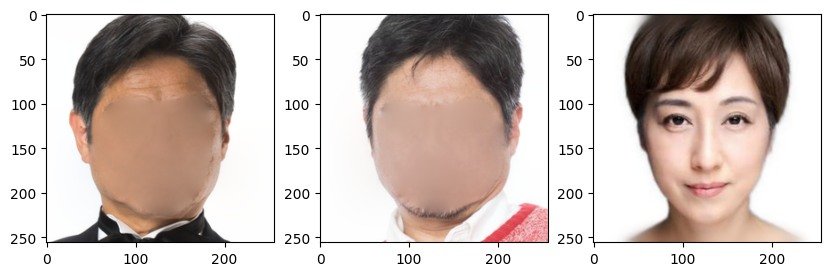

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(batch_from[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_from[1].permute([1, 2, 0]) / 2 + 0.5)
ax[2].imshow(batch_to[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

# Encode

In [55]:
cond_to = model.encode(batch_to.to(device))
cond_to_norm = cls_model.normalize(cond_to)
xT_to = model.encode_stochastic(batch_to.to(device), cond_to, T=250)

cond_from = model.encode(batch_from.to(device))
xT_from =  model.encode_stochastic(batch_from.to(device), cond_from, T=250)

In [68]:
beta = 0.5
xT_change = xT_from[1] - xT_from[0]
# xT_change = from_xT[1]*(1-beta) + from_xT[0]*beta
cond_change = cls_model.normalize(cond_from[1][None]) - cls_model.normalize(cond_from[0][None])

xTs = torch.tensor([], device=device)
conds = torch.tensor([], device=device)
alpha = torch.tensor(np.linspace(0, 1.2, 7, dtype=np.float32)).to(conds.device)

for alp in alpha:
    xT2 = (1-alp)*xT_to + alp * xT_change
    xTs = torch.cat([xTs, xT2], dim=0)
    cond2 = (1-alp)*cond_to_norm + alp * cond_change
    cond2 = cls_model.denormalize(cond2)
    conds = torch.cat([conds, cond2], dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


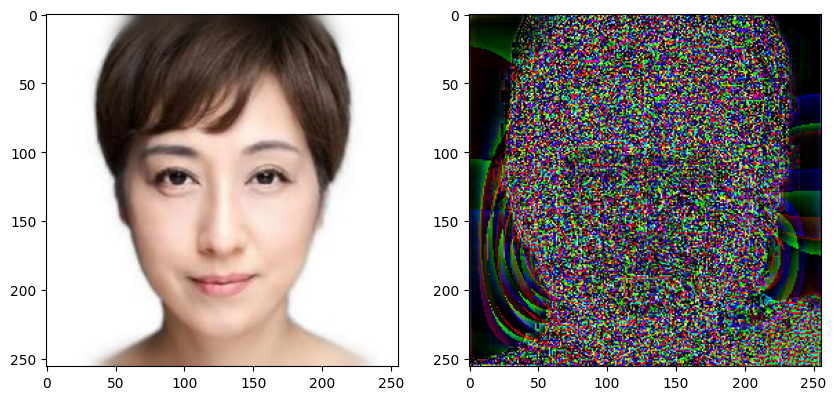

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch_to + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xTs[3].permute(1, 2, 0).cpu())

# Decode

In [70]:
preds = torch.tensor([], device=device)
for i in range(len(alpha)):
    pred = model.render(xTs[i][None], conds[i][None], T=20)
    preds = torch.cat([preds, pred], dim=0)

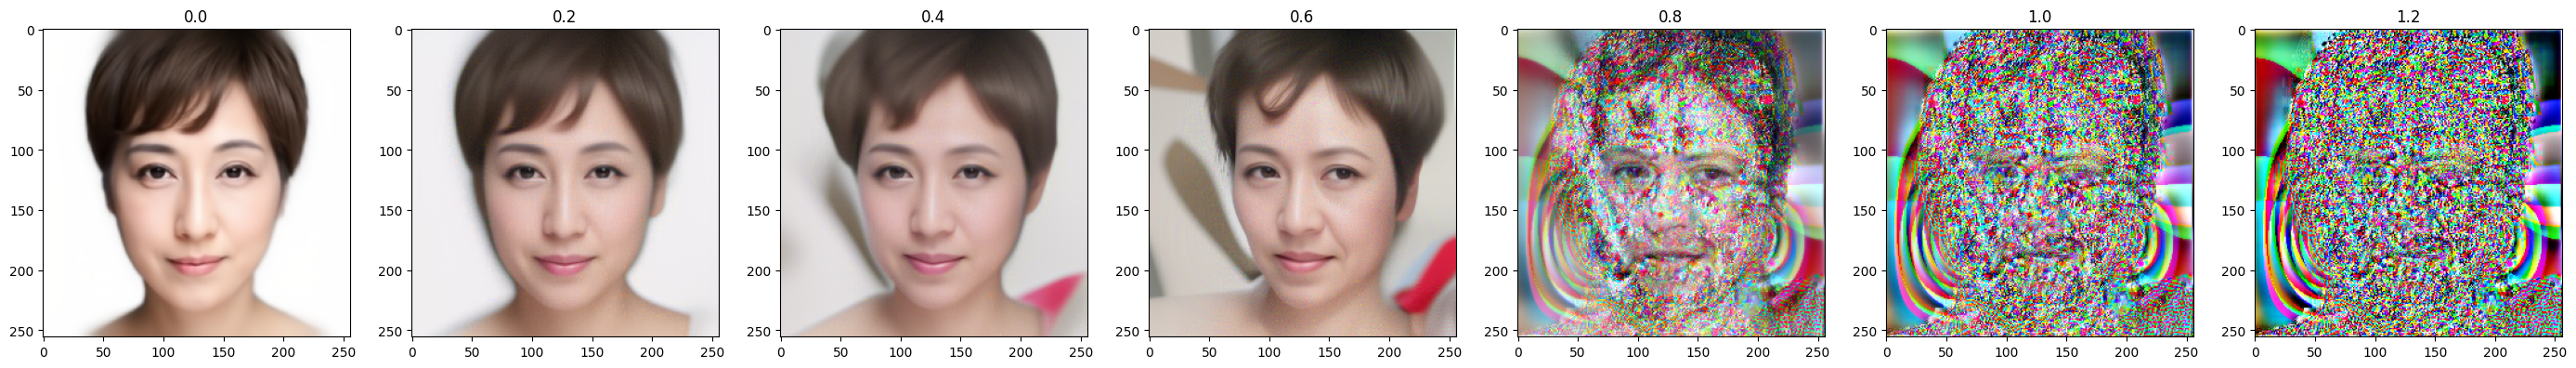

In [71]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(alpha), figsize=(5 * len(alpha), 5))
for i in range(len(alpha)):
    ax[i].imshow(preds[i].permute(1, 2, 0).cpu())
    ax[i].set_title(f'{alpha[i]:.2}')

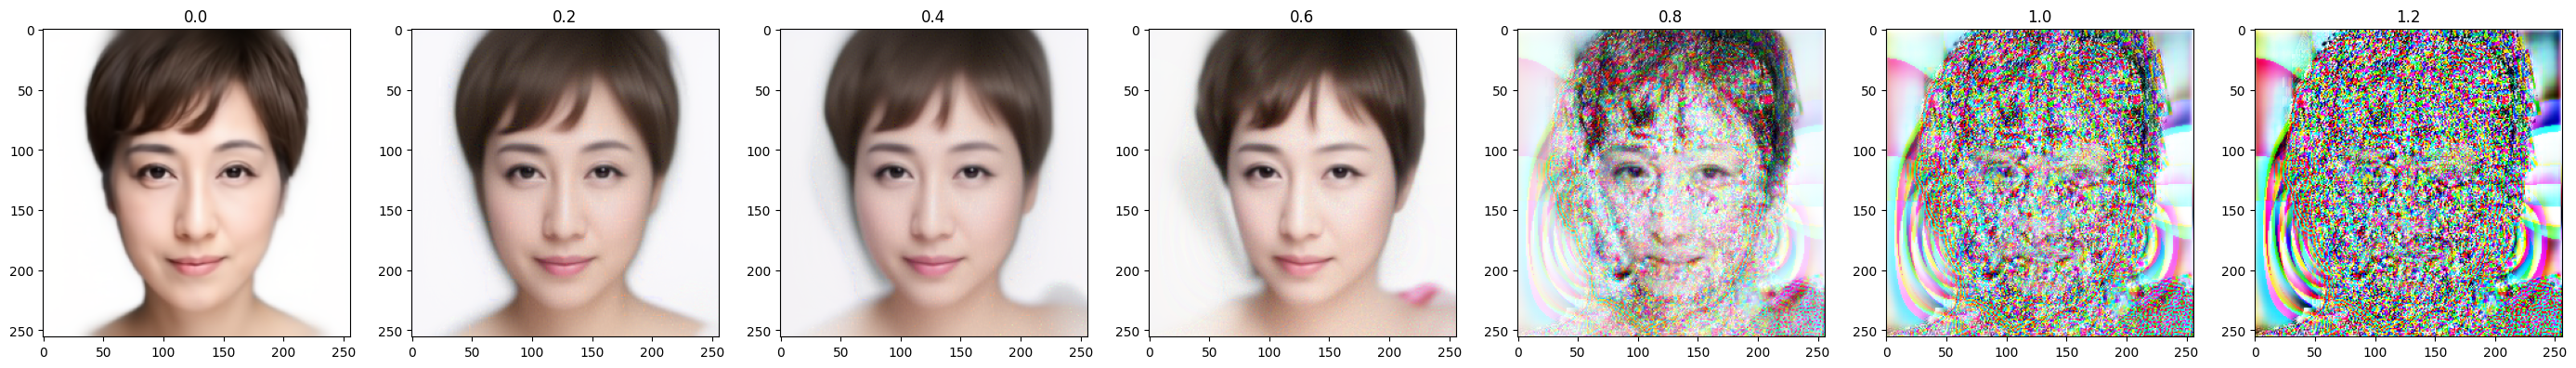

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(alpha), figsize=(5 * len(alpha), 5))
for i in range(len(alpha)):
    ax[i].imshow(preds[i].permute(1, 2, 0).cpu())
    ax[i].set_title(f'{alpha[i]:.2}')